In [420]:
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [421]:
def test_unit_root(y):
    if adfuller(y)[1] <= .05:
        print("Reject Unit Root")
    else: print('Cannot Reject Unit Root')

# AR(1,1)

In [422]:
#np.random.seed(12345)
arparams = np.array([.75])
maparams = np.array([.25])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y1 = sm.tsa.arma_generate_sample(ar, ma, 250)
model1 = sm.tsa.ARMA(y1, (1, 1)).fit(trend='nc', disp=0)
model1.params

array([0.75392977, 0.2306961 ])

In [423]:
test_unit_root(y1)

Reject Unit Root


# AR(2,0)

In [424]:
import numpy as np
#np.random.seed(12345)
arparams = np.array([.55, -.15])
maparams = np.array([0, 0])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y2 = sm.tsa.arma_generate_sample(ar, ma, 250)
model2 = sm.tsa.ARMA(y2, (2, 0)).fit(trend='nc', disp=0)
model2.params

array([ 0.61855004, -0.13195939])

In [425]:
test_unit_root(y2)

Reject Unit Root


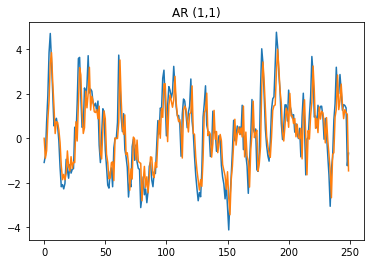

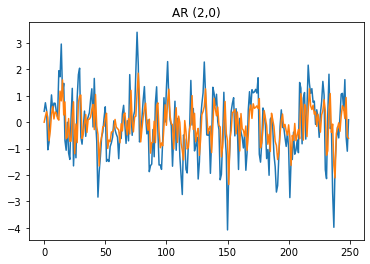

In [426]:
plt.plot(y1)
plt.plot(model1.fittedvalues)
plt.title('AR (1,1)')
plt.show()
plt.plot(y2)
plt.plot(model2.fittedvalues)
plt.title('AR (2,0)')
plt.show()

\begin{split}y_t & = Z_t \alpha_t + d_t + \varepsilon_t \\
\alpha_t & = T_t \alpha_{t-1} + c_t + R_t \eta_t \\\end{split}

* Z is design
* T is transition
* R is election

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.representation.Representation.html

In [427]:
class ARMA11(sm.tsa.statespace.MLEModel):
    start_params = [0, 0, 1]
    param_names = ['phi', 'theta', 'sigma2']

    def __init__(self, endog):
        super(ARMA11, self).__init__(
            endog, k_states=2, k_posdef=1, initialization='stationary')
        # Fix Values Here
        self['design', 0, 0] = 1.
        self['transition', 1, 0] = 1.
        self['selection', 0, 0] = 1.

    def update(self, params, **kwargs):
        # Transform the parameters if they are not yet transformed
        params = super(ARMA11, self).update(params, **kwargs)
        # Choose what to update here

        self['design', 0, 1] = params[1]
        self['transition', 0, 0] = params[0]
        self['state_cov', 0, 0] = params[2]

In [428]:
model = ARMA11(y1)
results = model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  250
Model:                         ARMA11   Log Likelihood                -345.509
Date:                Mon, 14 Sep 2020   AIC                            697.019
Time:                        23:44:36   BIC                            707.583
Sample:                             0   HQIC                           701.271
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
phi            0.7539      0.058     12.900      0.000       0.639       0.868
theta          0.2307      0.084      2.758      0.006       0.067       0.395
sigma2         0.9243      0.088     10.538      0.0

In [429]:
class ARMA20(sm.tsa.statespace.MLEModel):
    start_params = [0, 0, .1]
    param_names = ['phi1', 'phi2', 'sigma2']

    def __init__(self, endog):
        super(ARMA20, self).__init__(
            endog, k_states=2, k_posdef=1, initialization='stationary')

        self['design'] = [1, 0]
        self['transition'] = [[0, 0],
                            [1, 0]]
        self['selection', 0, 0] = 1

    def update(self, params, **kwargs):
        # Transform the parameters if they are not yet transformed
        params = super(ARMA20, self).update(params, **kwargs)
        #print(params[0], params[1], params[2])

        self['transition', 0, :] = params[:2]
        self['state_cov', 0, 0] = params[2]

In [430]:
model = ARMA20(y2)
results = model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  250
Model:                         ARMA20   Log Likelihood                -355.131
Date:                Mon, 14 Sep 2020   AIC                            716.262
Time:                        23:44:49   BIC                            726.826
Sample:                             0   HQIC                           720.514
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
phi1           0.6185      0.066      9.399      0.000       0.490       0.748
phi2          -0.1319      0.072     -1.832      0.067      -0.273       0.009
sigma2         1.0016      0.088     11.329      0.0

# AR(P,Q)

http://www.chadfulton.com/files/fulton_statsmodels_2017_v1.pdf  
https://robjhyndman.com/talks/ABS3.pdf  
https://faculty.washington.edu/ezivot/econ584/notes/statespacemodels.pdf  

In [529]:
class ARMAPQ(sm.tsa.statespace.MLEModel):
    start_params = None
    param_names = None
    def __init__(self, endog, p, q):
        self.p = p
        self.q = q
        r = max(p, q + 1)
        
        super(ARMAPQ, self).__init__(
            endog, k_states=r, k_posdef=1, initialization='stationary')
        # Specify the fixed elements of the state space matrices
        self['transition'] = np.hstack((np.zeros((r, 1)), np.vstack((np.eye(r - 1), np.zeros(r - 1)))))
        self['design', 0, 0] = 1
        self['selection', 0, 0] = 1
        self.initialize_approximate_diffuse()
        self.loglikelihood_burn = 1
        if self.start_params is None:
            self.start_params = np.zeros(p + q + 1)MCMC
            self.start_params[-1] = 1
            self.param_names = ['phi' + str(x + 1) for x in range(p)] + \
            ['theta' + str(x + 1) for x in range(q)] + \
            ['sigma2']

    def update(self, params, **kwargs):
        # Specify which parts of the state space matrices you want to update
        params = super(ARMAPQ, self).update(params, **kwargs)
        self['transition', 0:self.p, 0] = params[0:self.p]
        self['selection', 1:(self.q + 1), 0] = params[self.p:(self.p + self.q)]
        self['state_cov', 0, 0] = params[-1]

In [539]:
model = ARMAPQ(y1, 1, 1)
results = model.fit()

In [577]:
T = model['transition']

In [579]:
T

array([[0.75568944, 1.        ],
       [0.        , 0.        ]])

In [583]:
np.block([[T,T*0], [0*T,T]])

array([[0.75568944, 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.75568944, 1.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [540]:
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  250
Model:                         ARMAPQ   Log Likelihood                -350.786
Date:                Tue, 15 Sep 2020   AIC                            707.571
Time:                        00:46:51   BIC                            718.124
Sample:                             0   HQIC                           711.819
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
phi1           0.7557      0.059     12.870      0.000       0.641       0.871
theta1         0.2310      0.084      2.748      0.006       0.066       0.396
sigma2         0.9302      0.089     10.457      0.0

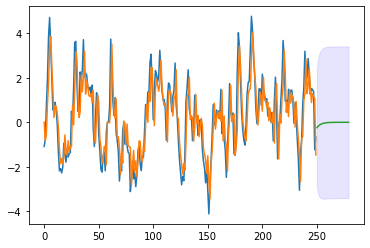

In [584]:
#fcast = results.get_prediction(start=250, end=280)
pred = results.get_prediction(start=251, end=280)
fcast = pred.predicted_mean # [2005-01-01 2.439005 ...
PI = pred.conf_int() # [2005-01-01

plt.plot(y1)
plt.plot(results.fittedvalues)
plt.plot(range(250, 280), fcast)
plt.fill_between(range(250, 280), PI[:,0], PI[:,1], color='b', alpha=.1)